# OOS 

In [1]:
import data_loading
import numpy as np

In [173]:
percentile_rank_chars, _, chars, dates,\
    returns, _, rfts, monthly_updates = data_loading.get_data_panel("../Data/raw_chars_returns_df_all_dates_yearly_fb.fthr",
                                                            "../Data/ff_rf.csv", computstat_data_present_filter=True,
                                                                              financial_firm_filter=False)

Index(['A2ME', 'AC', 'AT', 'ATO', 'B2M', 'BETA_d', 'BETA_m', 'C2A', 'CF2B',
       'CF2P', 'CTO', 'D2A', 'D2P', 'DPI2A', 'E2P', 'FC2Y', 'HIGH52', 'INV',
       'IdioVol', 'LEV', 'ME', 'NI', 'NOA', 'OA', 'OL', 'OP', 'PCM', 'PM',
       'PROF', 'Q', 'R12_2', 'R12_7', 'R2_1', 'R36_13', 'R60_13', 'RNA', 'ROA',
       'ROE', 'RVAR', 'S2P', 'SGA2S', 'SPREAD', 'SUV', 'TURN', 'VAR', 'return',
       'date', 'permno', 'monthly_update'],
      dtype='object')
['A2ME' 'AC' 'AT' 'ATO' 'B2M' 'BETA_d' 'BETA_m' 'C2A' 'CF2B' 'CF2P' 'CTO'
 'D2A' 'D2P' 'DPI2A' 'E2P' 'FC2Y' 'HIGH52' 'INV' 'IdioVol' 'LEV' 'ME' 'NI'
 'NOA' 'OA' 'OL' 'OP' 'PCM' 'PM' 'PROF' 'Q' 'R12_2' 'R12_7' 'R2_1'
 'R36_13' 'R60_13' 'RNA' 'ROA' 'ROE' 'RVAR' 'S2P' 'SGA2S' 'SPREAD' 'SUV'
 'TURN' 'VAR']


100%|████████████████████████████████████████████████████████████████████████████| 648/648 [03:15<00:00,  3.32it/s]


In [3]:
excess_returns = returns - np.expand_dims(np.array(rfts), axis=1)

In [4]:
excess_returns.shape

(648, 22630)

In [5]:
rft_map = {i: rf for i, rf in enumerate(rfts)}

In [6]:
import numpy as np

In [7]:
any_present = np.any(~np.isnan(percentile_rank_chars), axis=2)
present_counts = np.sum(np.sum(np.logical_and(~np.isnan(percentile_rank_chars),
                                             np.expand_dims(any_present, axis=2)), axis=0), axis=0)
del any_present

In [8]:
ordering = np.argsort(present_counts)[::-1]
print(chars[ordering])
percentile_rank_chars = percentile_rank_chars[:,:,ordering]
chars = chars[ordering]

['ME' 'R2_1' 'D2P' 'SPREAD' 'RVAR' 'VAR' 'IdioVol' 'TURN' 'SUV' 'R12_7'
 'CF2P' 'E2P' 'R12_2' 'S2P' 'B2M' 'CF2B' 'AT' 'A2ME' 'Q' 'PROF' 'PM' 'PCM'
 'BETA_m' 'C2A' 'OL' 'ROE' 'CTO' 'ATO' 'LEV' 'NOA' 'ROA' 'RNA' 'OP' 'NI'
 'INV' 'BETA_d' 'R36_13' 'D2A' 'FC2Y' 'SGA2S' 'OA' 'AC' 'HIGH52' 'R60_13'
 'DPI2A']


In [9]:
del percentile_rank_chars

In [10]:
def load_imputation(name, full=False):
    base_path = '../Data/'
    result_file_name = base_path + name + '.npz'
    res = np.load(result_file_name)
    if not full:
        return res['data']
    else:
        return res['data'], res['dates'], res['permnos'], res['chars']

In [11]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [12]:
import importlib
import eval_fn
importlib.reload(data_loading)
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/eval_fn.py'>

In [13]:
return_lag = 3
gamma_ts = load_imputation('MAR_xs_factors_cs236_2')
print("loaded")
first_masked_data = load_imputation('MAR_fit_data_cs236')[:, :, ordering]
train_data_seq = data_loading.get_data(first_masked_data[:400], min_chars_present=10, fill_val=-1, 
                                   gamma_ts=gamma_ts[:400], ordered=True,
                                        return_panel=excess_returns[return_lag:400+return_lag],
                                      t_start=return_lag)

del first_masked_data
print("loaded")
masked_data = load_imputation('MAR_fit_data_cs236_2')[:, :, ordering]
print("loaded")
eval_data = load_imputation('MAR_eval_data_cs236_2')[:, :, ordering]
print("loaded")
eval_data_seq = data_loading.get_data(masked_data[400:500], min_chars_present=10, fill_val=-1, 
                                   gamma_ts=gamma_ts[400:500], ordered=False,
                    oos_mask=~np.isnan(eval_data[400:500]), oos_eval_data=eval_data[400:500],
                                        return_panel=excess_returns[400+return_lag:500+return_lag],
                                      t_start=return_lag+400)
test_data_seq = data_loading.get_data(masked_data[500:-return_lag], min_chars_present=10, fill_val=-1, 
                                   gamma_ts=gamma_ts[500:-return_lag], ordered=False,
                    oos_mask=~np.isnan(eval_data[500:-return_lag]), oos_eval_data=eval_data[500:-return_lag],
                                        return_panel=excess_returns[500+return_lag:],
                                      t_start=return_lag+500)
del masked_data
del eval_data

loaded
1578149


100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 36.25it/s]


loaded
loaded
loaded


100%|████████████████████████████████████████████████████████████████████████████| 145/145 [00:02<00:00, 62.28it/s]


In [14]:
len(train_data_seq), len(eval_data_seq), len(test_data_seq),

(8745, 2970, 2700)

In [15]:
importlib.reload(data_loading)

<module 'data_loading' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/data_loading.py'>

In [31]:
chunk_size = 20
batch_size = 100

all_dataset = data_loading.ListDatasetWithFactors(train_data_seq, batch_size=chunk_size,return_returns=True)
train_data_loader = data_loading.DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

all_dataset = data_loading.ListDatasetWithFactors(eval_data_seq, batch_size=chunk_size,
                                                 return_oos_data=True,return_returns=True)
eval_data_loader = data_loading.DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

all_dataset = data_loading.ListDatasetWithFactors(test_data_seq, batch_size=chunk_size,
                                                 return_oos_data=True,return_returns=True)
test_data_loader = data_loading.DataLoader(all_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [17]:
import models
import loss_functions
from tqdm.notebook import tqdm

In [18]:
import numpy as np
import csv
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import time

In [19]:
import models
import loss_functions
importlib.reload(models)

<module 'models' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/models.py'>

In [20]:
import importlib
importlib.reload(models)
importlib.reload(loss_functions)

<module 'loss_functions' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/loss_functions.py'>

# Returns

In [22]:
def markowitz(factors):
    cov = np.cov(factors.T)
    mu = np.mean(factors, axis=0)
    print(cov.shape, mu.shape)
    return np.linalg.solve(cov, mu) 

In [25]:
importlib.reload(models)

<module 'models' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/models.py'>

In [36]:
exp_batch_size=100

In [56]:
torch.manual_seed(0)
ar_model = models.Beta_NADE(hidden_state_dim=0, latent_dimensions=15, predict_returns=True)
exp_batch_size=100

num_epochs = 2
eval_freq = 10

optimizer = torch.optim.AdamW(ar_model.parameters(), lr=0.01, weight_decay=0.1)


scheduler = MultiStepLR(optimizer, [20, 35], gamma=0.1, last_epoch=-1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')

ar_model = ar_model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    ar_losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):

        ts_idxs, stock_idxs, data, mask, ordered_mask, factors, return_sample = data
        assert not torch.isnan(data).any()
#         print(data, mask)
        assert not torch.logical_and(data <= 0, ~mask).any(), torch.min(data * mask)

        C_train = data.transpose_(0, 1).float().to(device)[:-1]

        C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
        return_sample = return_sample.float().to(device).transpose_(0, 1)[:-1]
        C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]

        factors = factors.transpose_(0, 1).float().to(device)[1:]

        train_input = torch.cat([C_train, C_mask, factors], axis=2)


        if train_input.shape[1] > 0:

            batch_size, batch_length, dim = C_train.shape
            model_input = C_train.reshape(batch_size * batch_length, dim)

            C_ordered_mask_reshape = C_ordered_mask.reshape(batch_size * batch_length, 45)
            C_train_reshape = C_train.reshape(batch_size * batch_length, 45)
            return_sample_reshape = return_sample.reshape(batch_size * batch_length, 1)

            alphas_pred, betas_pred, return_mus, return_sigmas = ar_model(model_input)

            ar_loss = loss_fn(C_train_reshape,
                              alphas_pred, betas_pred, mask=C_ordered_mask_reshape,
                             reduce_axis=1, ret_mus=return_mus, ret_sigmas=return_sigmas,
                             return_gts=return_sample_reshape).mean()

            net_loss = ar_loss
            net_loss.backward()
            ar_losses.append(ar_loss.data.detach().cpu().numpy())


            optimizer.step()
            ar_model.zero_grad()
            optimizer.zero_grad()   

    print(f'epoch {epoch}, avg ar model loss {np.mean(ar_losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()
    if (epoch + 1) % eval_freq == 0 or np.mean(ar_losses) <= -15:
        print(eval_fn.eval_model_is(chars, exp_batch_size, None, ar_model, train_data_loader, return_metrics=True, expect_oos_data=False))
        ar_model.predict_returns = False
        print(eval_fn.eval_model_oos(chars, exp_batch_size, None, ar_model, eval_data_loader))
        ar_model.predict_returns = True

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True) torch.Size([46, 45])
torch device is cuda:0
epoch 0


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 0, avg ar model loss 33.226531982421875
epoch 0 took 0.397344179948171 minutes
epoch 1


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 1, avg ar model loss -2.35969614982605
epoch 1 took 0.4177919546763102 minutes


In [83]:
importlib.reload(models)
importlib.reload(eval_fn)
importlib.reload(loss_functions)


<module 'loss_functions' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/loss_functions.py'>

In [84]:
ar_model.predict_returns = False
print(eval_fn.eval_model_oos(chars, exp_batch_size, None, ar_model, eval_data_loader))
ar_model.predict_returns = True

  0%|          | 0/64 [00:00<?, ?it/s]

([('ME', 0.27624345), ('R2_1', 0.29071453), ('D2P', 0.2602412), ('SPREAD', 0.24409224), ('RVAR', 0.1425582), ('VAR', 0.14030018), ('IdioVol', 0.14934045), ('TURN', 0.28621265), ('SUV', 0.28335705), ('R12_7', 0.28669268), ('CF2P', 0.2540215), ('E2P', 0.26428276), ('R12_2', 0.26701814), ('S2P', 0.292448), ('B2M', 0.1486726), ('CF2B', 0.28124312), ('AT', 0.2548259), ('A2ME', 0.28786734), ('Q', 0.26716834), ('PROF', 0.29937845), ('PM', 0.21224505), ('PCM', 0.28532457), ('BETA_m', 0.25047293), ('C2A', 0.2855273), ('OL', 0.289188), ('ROE', 0.29118013), ('CTO', 0.2842887), ('ATO', 0.29274514), ('LEV', 0.28032345), ('NOA', 0.29036328), ('ROA', 0.26882234), ('RNA', 0.27770853), ('OP', 0.1759143), ('NI', 0.28737843), ('INV', 0.17837805), ('BETA_d', 0.2333447), ('R36_13', 0.20897608), ('D2A', 0.2842144), ('FC2Y', 0.1648383), ('SGA2S', 0.2546367), ('OA', 0.29199597), ('AC', 0.2915303), ('HIGH52', 0.15423967), ('R60_13', 0.17509651), ('DPI2A', 0.25642553)], 0.2547636, -1.1918643)


In [42]:
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/eval_fn.py'>

In [46]:
is_hidden, is_returns = eval_fn.get_factors_returns(expected_batch_dim=exp_batch_size, model=None, ar_model=ar_model, 
                                            data_loader=train_data_loader, expect_oos_data=False)

eval_hidden, eval_returns = eval_fn.get_factors_returns(expected_batch_dim=exp_batch_size, model=None,
                                                        ar_model=ar_model, 
                                            data_loader=eval_data_loader, expect_oos_data=True)


is_factors = eval_fn.get_factors(is_hidden, is_returns).squeeze()

eval_factors = eval_fn.get_factors(eval_hidden, eval_returns).squeeze()

weights = markowitz(is_factors.squeeze())

np.mean(is_factors @ weights) / np.std(is_factors @ weights),\
    np.mean(eval_factors @ weights) / np.std(eval_factors @ weights)

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

(15, 15) (15,)


(1.0377766770696475, 0.1495394521971675)

In [47]:
test_hidden, test_returns = eval_fn.get_factors_returns(expected_batch_dim=exp_batch_size, model=None,
                                                        ar_model=ar_model, 
                                            data_loader=test_data_loader, expect_oos_data=True)
test_factors = eval_fn.get_factors(test_hidden, test_returns).squeeze()
np.mean(test_factors @ weights) / np.std(test_factors @ weights)

  0%|          | 0/77 [00:00<?, ?it/s]

0.19696000456025206

In [226]:
importlib.reload(eval_fn)
importlib.reload(models)


<module 'models' from '/home/selwin_p_george/CS 236 Project/Code/models.py'>

In [203]:
importlib.reload(models)

<module 'models' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/models.py'>

In [209]:
torch.manual_seed(0)
exp_batch_size = 100
# model = models.XSCharLSTM(input_dim=96, hidden_dims=[30, 40], num_layers=4, batch_size=exp_batch_size)

ar_model = models.Beta_NADE(hidden_state_dim=30, latent_dimensions=15, predict_returns=True)

num_epochs = 10

eval_freq = 1

# optimizer = torch.optim.AdamW(list(model.parameters()) + list(ar_model.parameters()), lr=0.01,
#                              weight_decay=0.01)
optimizer = torch.optim.AdamW(ar_model.parameters(), lr=0.01,
                             weight_decay=0.01)


scheduler = MultiStepLR(optimizer, [30], gamma=0.1, last_epoch=-1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
ar_model = ar_model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    ar_losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        ts_idxs, stock_idxs, data, mask, ordered_mask, factors, return_sample = data
        assert not torch.isnan(data).any()
#         print(data, mask)
        assert not torch.logical_and(data <= 0, ~mask).any(), torch.min(data * mask)
        
        C_train = data.transpose_(0, 1).float().to(device)[:-1]
        
        C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
        C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]
        return_sample = return_sample.float().to(device).transpose_(0, 1)[:-1]
        factors = factors.transpose_(0, 1).float().to(device)[1:]
        
        train_input = torch.cat([C_train, C_mask, factors], axis=2)
        
      
        if train_input.shape[1] == exp_batch_size:
            alpha_pred, beta_pred, hidden_out = model(train_input)
            loss = loss_fn(C_train[1:], alpha_pred[:-1], beta_pred[:-1], mask=C_mask[1:]).mean()
            assert not torch.isnan(loss).any()
            
#             loss.backward()
            losses.append(loss.data.detach().cpu().numpy())
            
#             print(hidden_out.shape, C_train.shape)
            model_input = torch.cat([hidden_out[:-1].detach(), C_train[1:]], axis=2)
            batch_dim, batch_length, dim = model_input.shape
            model_input = model_input.reshape(batch_dim * batch_length, dim)
            
            C_ordered_mask_reshape = C_ordered_mask[1:].reshape(batch_dim * batch_length, 45)
            C_train_reshape = C_train[1:].reshape(batch_dim * batch_length, 45)
            return_sample_reshape = return_sample[1:].reshape(batch_dim * batch_length, 1)
            
            alphas_pred, betas_pred, return_mus, return_sigmas = ar_model(model_input)
            
            
            ar_loss = loss_fn(C_train_reshape,
                              alphas_pred, betas_pred, mask=C_ordered_mask_reshape,
                             reduce_axis=1, ret_mus=return_mus, ret_sigmas=return_sigmas,
                             return_gts=return_sample_reshape).mean()
            
#             net_loss = ar_loss + loss
            net_loss = ar_loss
            net_loss.backward()
            ar_losses.append(ar_loss.data.detach().cpu().numpy())
            

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()       

    print(f'epoch {epoch} avg lstm loss {np.mean(losses)}, avg ar model loss {np.mean(ar_losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()
#     if (epoch + 1) % eval_freq == 0:
#         print(eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, train_data_loader, return_metrics=True, expect_oos_data=False))
#         print(eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, eval_data_loader, return_metrics=True, expect_oos_data=True))
#         print(eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, test_data_loader, return_metrics=True, expect_oos_data=True))
#         ar_model.predict_returns = False
#         print(eval_fn.eval_model_oos(chars, exp_batch_size ,model, ar_model, eval_data_loader))
#         ar_model.predict_returns = True
#         print(eval_fn.eval_ts_model_oos(chars, exp_batch_size,model, eval_data_loader))

Parameter containing:
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], requires_grad=True) torch.Size([46, 75])
torch device is cuda:0
epoch 0


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 0 avg lstm loss -37.02377700805664, avg ar model loss 37.53178405761719
epoch 0 took 0.40328752994537354 minutes
epoch 1


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 1 avg lstm loss -37.01823425292969, avg ar model loss -16.200931549072266
epoch 1 took 0.41943745613098143 minutes
epoch 2


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 2 avg lstm loss -37.02055358886719, avg ar model loss -46.954856872558594
epoch 2 took 0.40353940725326537 minutes
epoch 3


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 3 avg lstm loss -37.02040100097656, avg ar model loss -62.9410514831543
epoch 3 took 0.41858935753504434 minutes
epoch 4


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 4 avg lstm loss -37.02196502685547, avg ar model loss -69.98509216308594
epoch 4 took 0.42167458931605023 minutes
epoch 5


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 5 avg lstm loss -37.01866149902344, avg ar model loss -72.90165710449219
epoch 5 took 0.40137237707773843 minutes
epoch 6


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 6 avg lstm loss -37.020538330078125, avg ar model loss -75.50926971435547
epoch 6 took 0.4121622045834859 minutes
epoch 7


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 7 avg lstm loss -37.022010803222656, avg ar model loss -76.38477325439453
epoch 7 took 0.40046411752700806 minutes
epoch 8


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 8 avg lstm loss -37.02100372314453, avg ar model loss -76.75244140625
epoch 8 took 0.41623769601186117 minutes
epoch 9


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 9 avg lstm loss -37.018314361572266, avg ar model loss -76.99932098388672
epoch 9 took 0.4190632184346517 minutes


In [210]:
is_hidden, is_returns = eval_fn.get_factors_returns(expected_batch_dim=exp_batch_size, model=model, ar_model=ar_model, 
                                            data_loader=train_data_loader, expect_oos_data=False)

eval_hidden, eval_returns = eval_fn.get_factors_returns(expected_batch_dim=exp_batch_size, model=model,
                                                        ar_model=ar_model, 
                                            data_loader=eval_data_loader, expect_oos_data=True)


is_factors = eval_fn.get_factors(is_hidden, is_returns).squeeze()

eval_factors = eval_fn.get_factors(eval_hidden, eval_returns).squeeze()

weights = markowitz(is_factors.squeeze())

np.mean(is_factors @ weights) / np.std(is_factors @ weights),\
    np.mean(eval_factors @ weights) / np.std(eval_factors @ weights)

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

(15, 15) (15,)


(0.7759846955897648, -0.008126460087896345)

In [211]:
test_hidden, test_returns = eval_fn.get_factors_returns(expected_batch_dim=exp_batch_size, model=model,
                                                        ar_model=ar_model, 
                                            data_loader=test_data_loader, expect_oos_data=True)
test_factors = eval_fn.get_factors(test_hidden, test_returns).squeeze()
np.mean(test_factors @ weights) / np.std(test_factors @ weights)

  0%|          | 0/77 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
@ 4 [0.001977953470518154, 0.07228942832286273, 0.060806419080847954, -0.011563901668093778, 0.00026002147163928355, 0.06765969975657786, 0.14694436342760686, 0.11438107251132079, 0.07199162741893389, 0.22428494061929422, 0.12180594761727552]

In [290]:
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/Code/eval_fn.py'>

In [54]:
print(eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, train_data_loader,
                            return_metrics=True, expect_oos_data=False))
print(eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, eval_data_loader,
                            return_metrics=True, expect_oos_data=True))
print(eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, test_data_loader,
                            return_metrics=True, expect_oos_data=True))

  0%|          | 0/370 [00:00<?, ?it/s]

([('ME', 0.008855535), ('R2_1', 0.005697643), ('D2P', 0.006664096), ('SPREAD', 0.006592712), ('RVAR', 0.010827155), ('VAR', 0.010680204), ('IdioVol', 0.0073566106), ('TURN', 0.008304125), ('SUV', 0.006479653), ('R12_7', 0.00808746), ('CF2P', 0.008772258), ('E2P', 0.0065189614), ('R12_2', 0.006516874), ('S2P', 0.010319276), ('B2M', 0.008913608), ('CF2B', 0.0059681376), ('AT', 0.009221396), ('A2ME', 0.011313069), ('Q', 0.008509975), ('PROF', 0.0073401593), ('PM', 0.006816445), ('PCM', 0.0061151786), ('BETA_m', 0.007682451), ('C2A', 0.007110572), ('OL', 0.009288064), ('ROE', 0.008334165), ('CTO', 0.00988218), ('ATO', 0.0074910237), ('LEV', 0.00793094), ('NOA', 0.0064094993), ('ROA', 0.007166346), ('RNA', 0.0052977544), ('OP', 0.008012586), ('NI', 0.0067808195), ('INV', 0.00845476), ('BETA_d', 0.011215329), ('R36_13', 0.00838214), ('D2A', 0.00789875), ('FC2Y', 0.00909588), ('SGA2S', 0.0068780496), ('OA', 0.0069415015), ('AC', 0.007709105), ('HIGH52', 0.0072687874), ('R60_13', 0.011510137),

  0%|          | 0/64 [00:00<?, ?it/s]

([('ME', 0.023574956), ('R2_1', 0.0060577486), ('D2P', 0.0067644934), ('SPREAD', 0.0070135877), ('RVAR', 0.014069514), ('VAR', 0.01309053), ('IdioVol', 0.00834095), ('TURN', 0.00811267), ('SUV', 0.006484365), ('R12_7', 0.009563644), ('CF2P', 0.010170094), ('E2P', 0.009615251), ('R12_2', 0.008498814), ('S2P', 0.014604301), ('B2M', 0.009639329), ('CF2B', 0.006657991), ('AT', 0.022795033), ('A2ME', 0.02177308), ('Q', 0.012942621), ('PROF', 0.00855805), ('PM', 0.0075769103), ('PCM', 0.0076797763), ('BETA_m', 0.008974282), ('C2A', 0.007126991), ('OL', 0.010616143), ('ROE', 0.009237268), ('CTO', 0.011900856), ('ATO', 0.0083425455), ('LEV', 0.009050978), ('NOA', 0.0069432645), ('ROA', 0.009631499), ('RNA', 0.005374136), ('OP', 0.009074297), ('NI', 0.0071789715), ('INV', 0.009012678), ('BETA_d', 0.012404959), ('R36_13', 0.010076339), ('D2A', 0.009472845), ('FC2Y', 0.013879378), ('SGA2S', 0.0076361243), ('OA', 0.0071610636), ('AC', 0.008647786), ('HIGH52', 0.007755195), ('R60_13', 0.013583305),

  0%|          | 0/77 [00:00<?, ?it/s]

([('ME', 0.023513164), ('R2_1', 0.006032398), ('D2P', 0.0065296274), ('SPREAD', 0.007177128), ('RVAR', 0.01952104), ('VAR', 0.018112466), ('IdioVol', 0.008639014), ('TURN', 0.0082338685), ('SUV', 0.006549479), ('R12_7', 0.009524478), ('CF2P', 0.010289551), ('E2P', 0.009681828), ('R12_2', 0.008537712), ('S2P', 0.014661506), ('B2M', 0.009631356), ('CF2B', 0.006654524), ('AT', 0.023182243), ('A2ME', 0.026068285), ('Q', 0.014435117), ('PROF', 0.009324116), ('PM', 0.008073493), ('PCM', 0.008778263), ('BETA_m', 0.009323122), ('C2A', 0.0069631324), ('OL', 0.011486181), ('ROE', 0.009373486), ('CTO', 0.012633923), ('ATO', 0.008830623), ('LEV', 0.009046309), ('NOA', 0.0071038315), ('ROA', 0.010023458), ('RNA', 0.0052379104), ('OP', 0.009554217), ('NI', 0.0076110284), ('INV', 0.009000656), ('BETA_d', 0.01208373), ('R36_13', 0.0101788845), ('D2A', 0.010709635), ('FC2Y', 0.014697587), ('SGA2S', 0.009498118), ('OA', 0.0072221565), ('AC', 0.009426906), ('HIGH52', 0.007480727), ('R60_13', 0.014865014)

In [241]:
is_hidden, is_returns = eval_fn.get_factors_returns(exp_batch_size, model=model, ar_model=ar_model, 
                                            data_loader=train_data_loader, expect_oos_data=False)

eval_hidden, eval_returns = eval_fn.get_factors_returns(exp_batch_size, model=model, ar_model=ar_model, 
                                            data_loader=eval_data_loader, expect_oos_data=True)


is_factors = eval_fn.get_factors(is_hidden, is_returns).squeeze()

eval_factors = eval_fn.get_factors(eval_hidden, eval_returns).squeeze()

weights = markowitz(is_factors.squeeze())

np.mean(is_factors @ weights) / np.std(is_factors @ weights),\
    np.mean(eval_factors @ weights) / np.std(eval_factors @ weights)

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

(5, 5) (5,)


(0.138095236684946, 0.10802225494038135)

# OOS validation

49

In [125]:
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/eval_fn.py'>

In [127]:
torch.manual_seed(0)
exp_batch_size = 100
model = models.XSCharLSTM(input_dim=96, hidden_dims=[30, 30], num_layers=4, batch_size=exp_batch_size)

num_epochs = 20
eval_freq = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


scheduler = MultiStepLR(optimizer, [30], gamma=0.1, last_epoch=-1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        ts_idxs, stock_idxs, data, mask, ordered_mask, factors, return_sample = data
        assert not torch.isnan(data).any()
#         assert not (data <= 0).any(), torch.min(data)
#         print(data.shape)
        C_train = data.transpose_(0, 1).float().to(device)[:-1]
        
        C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
        C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]
        
        factors = factors.transpose_(0, 1).float().to(device)[1:]
        
        train_input = torch.cat([C_train, C_mask, factors], axis=2)
        if train_input.shape[1] == exp_batch_size and train_input.shape[2] > 0:
            alpha_pred, beta_pred, hidden_out = model(train_input)
#             print(hidden_out.shape)

            loss = loss_fn(C_train[1:], alpha_pred[:-1], beta_pred[:-1], mask=C_mask[1:]).mean()
            assert not torch.isnan(loss).any()

            loss.backward()
            losses.append(loss.data.cpu().detach().numpy())

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()       


    print(f'epoch {epoch} avg loss {np.mean(losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()
    if (epoch) % eval_freq == 0:
#         print("train is", eval_fn.eval_ts_model_is(chars, exp_batch_size, model, train_data_loader))
#         print("eval is", eval_fn.eval_ts_model_is(chars, exp_batch_size, model, eval_data_loader))
        print("eval oos", eval_fn.eval_ts_model_oos(chars, exp_batch_size, model, eval_data_loader))
        print("test oos", eval_fn.eval_ts_model_oos(chars, exp_batch_size, model, test_data_loader))
        

torch device is cuda:0
epoch 0


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 0 avg loss 19.876632690429688
epoch 0 took 0.1310057322184245 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.26309595), ('R2_1', 0.29270262), ('D2P', 0.25756076), ('SPREAD', 0.16491897), ('RVAR', 0.1502579), ('VAR', 0.14767343), ('IdioVol', 0.15719178), ('TURN', 0.29055732), ('SUV', 0.28396067), ('R12_7', 0.2857489), ('CF2P', 0.2474895), ('E2P', 0.2508824), ('R12_2', 0.27961594), ('S2P', 0.2952503), ('B2M', 0.29012042), ('CF2B', 0.27321962), ('AT', 0.21941195), ('A2ME', 0.2769044), ('Q', 0.27259365), ('PROF', 0.29590577), ('PM', 0.22646464), ('PCM', 0.2864225), ('BETA_m', 0.256671), ('C2A', 0.28463086), ('OL', 0.2768835), ('ROE', 0.26298422), ('CTO', 0.28862315), ('ATO', 0.29816708), ('LEV', 0.29333857), ('NOA', 0.29682016), ('ROA', 0.26291525), ('RNA', 0.2671224), ('OP', 0.2724555), ('NI', 0.28347522), ('INV', 0.2867042), ('BETA_d', 0.2630547), ('R36_13', 0.28565794), ('D2A', 0.28887153), ('FC2Y', 0.26234296), ('SGA2S', 0.26280707), ('OA', 0.2920981), ('AC', 0.2961573), ('HIGH52', 0.2322702), ('R60_13', 0.28759164), ('DPI2A', 0.2949238)], 0.26454479, -2.2079315)


  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.22437754), ('R2_1', 0.2972301), ('D2P', 0.2676452), ('SPREAD', 0.16340098), ('RVAR', 0.1564434), ('VAR', 0.16134353), ('IdioVol', 0.16419677), ('TURN', 0.31069756), ('SUV', 0.28488103), ('R12_7', 0.2890958), ('CF2P', 0.270206), ('E2P', 0.26209942), ('R12_2', 0.28516024), ('S2P', 0.2938093), ('B2M', 0.29381618), ('CF2B', 0.28152075), ('AT', 0.21991384), ('A2ME', 0.28761324), ('Q', 0.28915536), ('PROF', 0.30008572), ('PM', 0.24304327), ('PCM', 0.28410015), ('BETA_m', 0.28410023), ('C2A', 0.28947097), ('OL', 0.27897042), ('ROE', 0.26801452), ('CTO', 0.28840545), ('ATO', 0.29371038), ('LEV', 0.29079998), ('NOA', 0.29858202), ('ROA', 0.26042357), ('RNA', 0.27604452), ('OP', 0.27700657), ('NI', 0.28100514), ('INV', 0.29362032), ('BETA_d', 0.29343557), ('R36_13', 0.2764), ('D2A', 0.3099466), ('FC2Y', 0.28114206), ('SGA2S', 0.28222647), ('OA', 0.29050618), ('AC', 0.29564455), ('HIGH52', 0.23707673), ('R60_13', 0.28081828), ('DPI2A', 0.29470333)], 0.27004197, -1.974364)
epoc

  0%|          | 0/370 [00:00<?, ?it/s]

epoch 1 avg loss -5.972797870635986
epoch 1 took 0.13034491936365764 minutes
epoch 2


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 2 avg loss -8.856234550476074
epoch 2 took 0.13121496041615804 minutes
epoch 3


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 3 avg loss -9.392715454101562
epoch 3 took 0.13093676964441936 minutes
epoch 4


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 4 avg loss -9.632695198059082
epoch 4 took 0.1310149312019348 minutes
epoch 5


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 5 avg loss -10.31887435913086
epoch 5 took 0.12915482918421428 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.2794273), ('R2_1', 0.29357514), ('D2P', 0.26190984), ('SPREAD', 0.18729609), ('RVAR', 0.18723488), ('VAR', 0.18634138), ('IdioVol', 0.2101585), ('TURN', 0.27639967), ('SUV', 0.28433827), ('R12_7', 0.28707424), ('CF2P', 0.24243712), ('E2P', 0.26093397), ('R12_2', 0.28295594), ('S2P', 0.15935959), ('B2M', 0.2518018), ('CF2B', 0.2829218), ('AT', 0.25618878), ('A2ME', 0.1829505), ('Q', 0.2188643), ('PROF', 0.24363093), ('PM', 0.26153612), ('PCM', 0.2820972), ('BETA_m', 0.26077852), ('C2A', 0.2670879), ('OL', 0.1790707), ('ROE', 0.28671548), ('CTO', 0.14902511), ('ATO', 0.22241007), ('LEV', 0.2657816), ('NOA', 0.28442279), ('ROA', 0.27441034), ('RNA', 0.27631372), ('OP', 0.28695503), ('NI', 0.2757502), ('INV', 0.29983434), ('BETA_d', 0.26581872), ('R36_13', 0.29391217), ('D2A', 0.26446906), ('FC2Y', 0.24736285), ('SGA2S', 0.2449433), ('OA', 0.29144615), ('AC', 0.29435587), ('HIGH52', 0.25578), ('R60_13', 0.27770278), ('DPI2A', 0.29264235)], 0.2541427, 4.6514583)


  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.2566911), ('R2_1', 0.29786387), ('D2P', 0.27192086), ('SPREAD', 0.18779318), ('RVAR', 0.19371879), ('VAR', 0.20067221), ('IdioVol', 0.21858864), ('TURN', 0.29595596), ('SUV', 0.2848955), ('R12_7', 0.28859958), ('CF2P', 0.2603329), ('E2P', 0.26980522), ('R12_2', 0.28492272), ('S2P', 0.16375585), ('B2M', 0.22634047), ('CF2B', 0.29434443), ('AT', 0.24158053), ('A2ME', 0.18888418), ('Q', 0.21962461), ('PROF', 0.24982655), ('PM', 0.27265364), ('PCM', 0.27946734), ('BETA_m', 0.2844125), ('C2A', 0.26902184), ('OL', 0.18185984), ('ROE', 0.28731826), ('CTO', 0.15177947), ('ATO', 0.20764649), ('LEV', 0.2727472), ('NOA', 0.2900132), ('ROA', 0.27921492), ('RNA', 0.28467876), ('OP', 0.28768912), ('NI', 0.27536875), ('INV', 0.30607593), ('BETA_d', 0.29141232), ('R36_13', 0.282869), ('D2A', 0.2794798), ('FC2Y', 0.26047605), ('SGA2S', 0.25846615), ('OA', 0.29082108), ('AC', 0.29618222), ('HIGH52', 0.25770432), ('R60_13', 0.2670172), ('DPI2A', 0.29499757)], 0.2578998, 5.584263)
epoc

  0%|          | 0/370 [00:00<?, ?it/s]

epoch 6 avg loss -12.835031509399414
epoch 6 took 0.1299235701560974 minutes
epoch 7


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 7 avg loss -13.57624340057373
epoch 7 took 0.1313893437385559 minutes
epoch 8


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 8 avg loss -13.948187828063965
epoch 8 took 0.13258785009384155 minutes
epoch 9


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 9 avg loss -17.12700843811035
epoch 9 took 0.13060919841130575 minutes
epoch 10


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 10 avg loss -20.150447845458984
epoch 10 took 0.13196224768956502 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.19873655), ('R2_1', 0.29106057), ('D2P', 0.25888872), ('SPREAD', 0.18655449), ('RVAR', 0.16897723), ('VAR', 0.17712322), ('IdioVol', 0.19974825), ('TURN', 0.24338773), ('SUV', 0.28625697), ('R12_7', 0.2686119), ('CF2P', 0.21166044), ('E2P', 0.19363898), ('R12_2', 0.25148544), ('S2P', 0.12297259), ('B2M', 0.23200008), ('CF2B', 0.23620221), ('AT', 0.1887821), ('A2ME', 0.19230329), ('Q', 0.21734622), ('PROF', 0.21376139), ('PM', 0.13994946), ('PCM', 0.19511944), ('BETA_m', 0.22860628), ('C2A', 0.22000939), ('OL', 0.123909146), ('ROE', 0.23518787), ('CTO', 0.1270605), ('ATO', 0.19302164), ('LEV', 0.24526778), ('NOA', 0.20246433), ('ROA', 0.23624939), ('RNA', 0.19068772), ('OP', 0.1848702), ('NI', 0.27287516), ('INV', 0.26292378), ('BETA_d', 0.21477665), ('R36_13', 0.28164577), ('D2A', 0.2521546), ('FC2Y', 0.13177684), ('SGA2S', 0.13261706), ('OA', 0.2892876), ('AC', 0.2933253), ('HIGH52', 0.22386728), ('R60_13', 0.269824), ('DPI2A', 0.27746415)], 0.21698755, 5.9470057)


  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.19553794), ('R2_1', 0.29630142), ('D2P', 0.26824942), ('SPREAD', 0.18088695), ('RVAR', 0.17489561), ('VAR', 0.19076969), ('IdioVol', 0.20819026), ('TURN', 0.25931728), ('SUV', 0.2869282), ('R12_7', 0.2757924), ('CF2P', 0.23103745), ('E2P', 0.20466033), ('R12_2', 0.26190975), ('S2P', 0.12867256), ('B2M', 0.21726274), ('CF2B', 0.2506938), ('AT', 0.18801905), ('A2ME', 0.19611312), ('Q', 0.21860364), ('PROF', 0.21271563), ('PM', 0.15605955), ('PCM', 0.19726655), ('BETA_m', 0.26282093), ('C2A', 0.22617322), ('OL', 0.1311093), ('ROE', 0.24105549), ('CTO', 0.12745523), ('ATO', 0.18656261), ('LEV', 0.25491342), ('NOA', 0.20378529), ('ROA', 0.24468945), ('RNA', 0.21264964), ('OP', 0.20030265), ('NI', 0.2797225), ('INV', 0.27347553), ('BETA_d', 0.24139059), ('R36_13', 0.26577058), ('D2A', 0.26023567), ('FC2Y', 0.1390755), ('SGA2S', 0.1376789), ('OA', 0.28874868), ('AC', 0.29545814), ('HIGH52', 0.22739673), ('R60_13', 0.25180626), ('DPI2A', 0.27826515)], 0.22289832, 7.149735)


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 11 avg loss -23.12584114074707
epoch 11 took 0.13094874223073324 minutes
epoch 12


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 12 avg loss -25.33672523498535
epoch 12 took 0.13197648922602337 minutes
epoch 13


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 13 avg loss -27.618934631347656
epoch 13 took 0.13051761786142985 minutes
epoch 14


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 14 avg loss -29.70618438720703
epoch 14 took 0.1305336634318034 minutes
epoch 15


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 15 avg loss -31.3104190826416
epoch 15 took 0.13164707024892172 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.23559655), ('R2_1', 0.29738963), ('D2P', 0.23773225), ('SPREAD', 0.18751028), ('RVAR', 0.17300984), ('VAR', 0.18754494), ('IdioVol', 0.2281206), ('TURN', 0.24226314), ('SUV', 0.3040925), ('R12_7', 0.21095346), ('CF2P', 0.19349663), ('E2P', 0.16870044), ('R12_2', 0.21631503), ('S2P', 0.12057525), ('B2M', 0.15104601), ('CF2B', 0.23594183), ('AT', 0.21687953), ('A2ME', 0.18691711), ('Q', 0.20948112), ('PROF', 0.18204209), ('PM', 0.13964526), ('PCM', 0.1757497), ('BETA_m', 0.13909848), ('C2A', 0.19861937), ('OL', 0.11607511), ('ROE', 0.21938935), ('CTO', 0.11880245), ('ATO', 0.18163055), ('LEV', 0.17252065), ('NOA', 0.17396328), ('ROA', 0.20196241), ('RNA', 0.1870914), ('OP', 0.17482413), ('NI', 0.26352355), ('INV', 0.22328252), ('BETA_d', 0.15179168), ('R36_13', 0.21391593), ('D2A', 0.24022141), ('FC2Y', 0.12895176), ('SGA2S', 0.1138221), ('OA', 0.2890242), ('AC', 0.29443157), ('HIGH52', 0.20710482), ('R60_13', 0.20222735), ('DPI2A', 0.26978487)], 0.19962361, 16.061232

  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.2319854), ('R2_1', 0.3030579), ('D2P', 0.24843597), ('SPREAD', 0.18910907), ('RVAR', 0.17983772), ('VAR', 0.20177835), ('IdioVol', 0.23946124), ('TURN', 0.263703), ('SUV', 0.30942425), ('R12_7', 0.21539593), ('CF2P', 0.2171454), ('E2P', 0.1785698), ('R12_2', 0.21748509), ('S2P', 0.12645857), ('B2M', 0.1410697), ('CF2B', 0.2530269), ('AT', 0.21662612), ('A2ME', 0.19070825), ('Q', 0.2123953), ('PROF', 0.18410276), ('PM', 0.15168601), ('PCM', 0.17622936), ('BETA_m', 0.14944641), ('C2A', 0.21144198), ('OL', 0.1210381), ('ROE', 0.23024125), ('CTO', 0.11913729), ('ATO', 0.17682882), ('LEV', 0.17656742), ('NOA', 0.1757728), ('ROA', 0.21171111), ('RNA', 0.20880388), ('OP', 0.1852599), ('NI', 0.27121297), ('INV', 0.2373869), ('BETA_d', 0.17491136), ('R36_13', 0.20361283), ('D2A', 0.25630176), ('FC2Y', 0.12981892), ('SGA2S', 0.11481971), ('OA', 0.28847352), ('AC', 0.29539582), ('HIGH52', 0.2118152), ('R60_13', 0.1948309), ('DPI2A', 0.27286345)], 0.20589742, 17.195568)
epoch 1

  0%|          | 0/370 [00:00<?, ?it/s]

epoch 16 avg loss -32.706077575683594
epoch 16 took 0.13140314022699992 minutes
epoch 17


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 17 avg loss -33.837799072265625
epoch 17 took 0.1306575616200765 minutes
epoch 18


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 18 avg loss -35.04812240600586
epoch 18 took 0.12987303733825684 minutes
epoch 19


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 19 avg loss -36.24156188964844
epoch 19 took 0.13223708868026735 minutes


In [118]:
importlib.reload(loss_functions)
importlib.reload(eval_fn)
importlib.reload(loss_functions)
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/eval_fn.py'>

  0%|          | 0/370 [00:00<?, ?it/s]

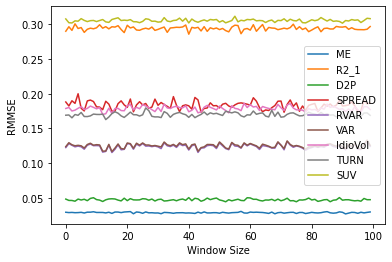

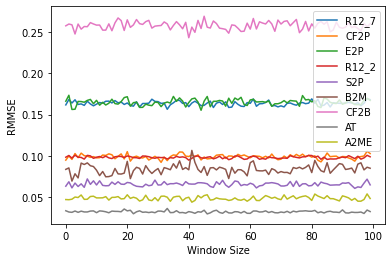

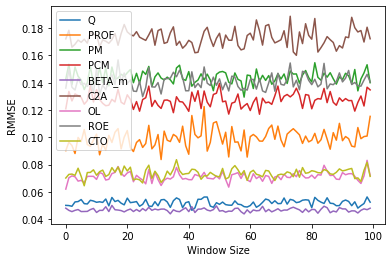

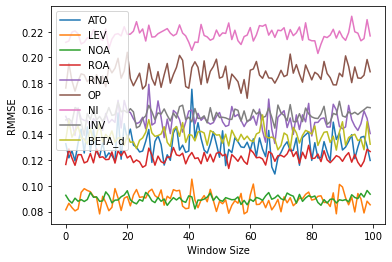

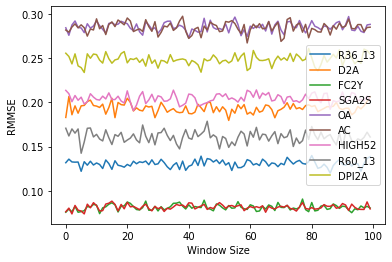

train is ([('ME', 0.02844139), ('R2_1', 0.29425007), ('D2P', 0.04697669), ('SPREAD', 0.18359005), ('RVAR', 0.123835884), ('VAR', 0.12506093), ('IdioVol', 0.17877655), ('TURN', 0.16992053), ('SUV', 0.3056337), ('R12_7', 0.16345851), ('CF2P', 0.098879635), ('E2P', 0.16498326), ('R12_2', 0.09793599), ('S2P', 0.06549711), ('B2M', 0.08369726), ('CF2B', 0.25790477), ('AT', 0.0319526), ('A2ME', 0.048547547), ('Q', 0.052153837), ('PROF', 0.099431984), ('PM', 0.14400847), ('PCM', 0.12738109), ('BETA_m', 0.04673309), ('C2A', 0.17273957), ('OL', 0.07124261), ('ROE', 0.14060333), ('CTO', 0.07371719), ('ATO', 0.13174683), ('LEV', 0.08911005), ('NOA', 0.08992866), ('ROA', 0.122261636), ('RNA', 0.15138921), ('OP', 0.18661283), ('NI', 0.21781416), ('INV', 0.15514264), ('BETA_d', 0.13880153), ('R36_13', 0.13085106), ('D2A', 0.1934219), ('FC2Y', 0.08147096), ('SGA2S', 0.08167805), ('OA', 0.28498933), ('AC', 0.28444418), ('HIGH52', 0.20445816), ('R60_13', 0.16120045), ('DPI2A', 0.24826589)], 0.14113204, 

In [119]:
print("train is", eval_fn.eval_ts_model_is(chars, exp_batch_size, model, train_data_loader, plot_ts=True))

In [113]:
print("train is", eval_fn.eval_ts_model_is(chars, exp_batch_size, model, train_data_loader))
print("eval is", eval_fn.eval_ts_model_is(chars, exp_batch_size, model, eval_data_loader))
print("eval oos", eval_fn.eval_ts_model_oos(chars, exp_batch_size, model, eval_data_loader))
print("test oos", eval_fn.eval_ts_model_oos(chars, exp_batch_size, model, test_data_loader))

  0%|          | 0/370 [00:00<?, ?it/s]

train is ([('ME', 0.028438823), ('R2_1', 0.29427224), ('D2P', 0.046970874), ('SPREAD', 0.18360311), ('RVAR', 0.12383765), ('VAR', 0.1250588), ('IdioVol', 0.17879096), ('TURN', 0.16989523), ('SUV', 0.3056352), ('R12_7', 0.16346207), ('CF2P', 0.09886185), ('E2P', 0.16496865), ('R12_2', 0.097931646), ('S2P', 0.06549332), ('B2M', 0.083712496), ('CF2B', 0.25790632), ('AT', 0.031943444), ('A2ME', 0.04855191), ('Q', 0.05215146), ('PROF', 0.09945324), ('PM', 0.14400688), ('PCM', 0.12738347), ('BETA_m', 0.046731967), ('C2A', 0.17270656), ('OL', 0.07125253), ('ROE', 0.14059982), ('CTO', 0.07371299), ('ATO', 0.13170703), ('LEV', 0.08912947), ('NOA', 0.08991741), ('ROA', 0.122259535), ('RNA', 0.15138267), ('OP', 0.18660463), ('NI', 0.21784036), ('INV', 0.15512581), ('BETA_d', 0.13878283), ('R36_13', 0.13086773), ('D2A', 0.19348069), ('FC2Y', 0.081476405), ('SGA2S', 0.081651725), ('OA', 0.28499758), ('AC', 0.28443238), ('HIGH52', 0.20447092), ('R60_13', 0.16121663), ('DPI2A', 0.24825244)], 0.141131

  0%|          | 0/64 [00:00<?, ?it/s]

eval is ([('ME', 0.12276274), ('R2_1', 0.304493), ('D2P', 0.08079332), ('SPREAD', 0.18643168), ('RVAR', 0.1650362), ('VAR', 0.1593834), ('IdioVol', 0.19681497), ('TURN', 0.18412888), ('SUV', 0.3118031), ('R12_7', 0.20074946), ('CF2P', 0.12833129), ('E2P', 0.17622028), ('R12_2', 0.12388219), ('S2P', 0.117818855), ('B2M', 0.1276569), ('CF2B', 0.24405752), ('AT', 0.14485338), ('A2ME', 0.12937972), ('Q', 0.09956542), ('PROF', 0.14025766), ('PM', 0.13833082), ('PCM', 0.14749447), ('BETA_m', 0.08493901), ('C2A', 0.1807973), ('OL', 0.104841866), ('ROE', 0.17457315), ('CTO', 0.096156076), ('ATO', 0.17695583), ('LEV', 0.15274), ('NOA', 0.1383196), ('ROA', 0.15714015), ('RNA', 0.19950514), ('OP', 0.18772823), ('NI', 0.23823644), ('INV', 0.19338143), ('BETA_d', 0.15714292), ('R36_13', 0.17699763), ('D2A', 0.22952463), ('FC2Y', 0.11188977), ('SGA2S', 0.10589813), ('OA', 0.29029554), ('AC', 0.29183617), ('HIGH52', 0.20380177), ('R60_13', 0.19412927), ('DPI2A', 0.26805323)], 0.17211397, -8.925081)


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.23568718), ('R2_1', 0.3047231), ('D2P', 0.23272187), ('SPREAD', 0.19110037), ('RVAR', 0.17243654), ('VAR', 0.18864681), ('IdioVol', 0.23387365), ('TURN', 0.22851521), ('SUV', 0.3110202), ('R12_7', 0.21510528), ('CF2P', 0.18609859), ('E2P', 0.17219348), ('R12_2', 0.22843991), ('S2P', 0.11965375), ('B2M', 0.13777065), ('CF2B', 0.2380854), ('AT', 0.21568604), ('A2ME', 0.18162751), ('Q', 0.21369441), ('PROF', 0.16188289), ('PM', 0.13243827), ('PCM', 0.15809111), ('BETA_m', 0.11448732), ('C2A', 0.18596537), ('OL', 0.10996518), ('ROE', 0.20586984), ('CTO', 0.12306754), ('ATO', 0.18236905), ('LEV', 0.17092487), ('NOA', 0.15953271), ('ROA', 0.18618117), ('RNA', 0.19127604), ('OP', 0.17802274), ('NI', 0.24221528), ('INV', 0.2061961), ('BETA_d', 0.15837342), ('R36_13', 0.18965684), ('D2A', 0.23097646), ('FC2Y', 0.1333221), ('SGA2S', 0.111329675), ('OA', 0.28906053), ('AC', 0.29242405), ('HIGH52', 0.20582227), ('R60_13', 0.19879763), ('DPI2A', 0.26685256)], 0.19538178, 22.9883

  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.23150781), ('R2_1', 0.30992007), ('D2P', 0.22472633), ('SPREAD', 0.18901123), ('RVAR', 0.1786773), ('VAR', 0.20273392), ('IdioVol', 0.24546531), ('TURN', 0.2343224), ('SUV', 0.31688762), ('R12_7', 0.21883771), ('CF2P', 0.19461055), ('E2P', 0.18200348), ('R12_2', 0.2284986), ('S2P', 0.12736163), ('B2M', 0.12992375), ('CF2B', 0.25453472), ('AT', 0.21515551), ('A2ME', 0.18482675), ('Q', 0.21630031), ('PROF', 0.16517581), ('PM', 0.14256832), ('PCM', 0.15541868), ('BETA_m', 0.120214306), ('C2A', 0.20352264), ('OL', 0.11262006), ('ROE', 0.21464609), ('CTO', 0.122829825), ('ATO', 0.17993328), ('LEV', 0.17218305), ('NOA', 0.16443609), ('ROA', 0.19530404), ('RNA', 0.21052733), ('OP', 0.18804324), ('NI', 0.2452252), ('INV', 0.214352), ('BETA_d', 0.18127643), ('R36_13', 0.18249989), ('D2A', 0.2305926), ('FC2Y', 0.13822718), ('SGA2S', 0.11427445), ('OA', 0.2887631), ('AC', 0.2929931), ('HIGH52', 0.20912081), ('R60_13', 0.19265015), ('DPI2A', 0.26799083)], 0.1997932, 23.519268)


In [101]:
torch.manual_seed(0)
exp_batch_size = 100
ar_model = models.Beta_NADE(hidden_state_dim=0, latent_dimensions=30)

num_epochs = 2
eval_freq = 1

optimizer = torch.optim.AdamW(ar_model.parameters(), lr=0.01,
                             weight_decay=0.01)

scheduler = MultiStepLR(optimizer, [20, 35], gamma=0.1, last_epoch=-1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
ar_model = ar_model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    ar_losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        ts_idxs, stock_idxs, data, mask, ordered_mask, factors, return_sample = data
        assert not torch.isnan(data).any()
#         print(data, mask)
        assert not torch.logical_and(data <= 0, ~mask).any(), torch.min(data * mask)
        
        C_train = data.transpose_(0, 1).float().to(device)[:-1]
        
        C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
        C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]
        
        factors = factors.transpose_(0, 1).float().to(device)[1:]
        
        train_input = torch.cat([C_train, C_mask, factors], axis=2)
        
      
        if train_input.shape[1] > 0:
            
            batch_size, batch_length, dim = C_train.shape
            model_input = C_train.reshape(batch_size * batch_length, dim)
            
            C_ordered_mask_reshape = C_ordered_mask.reshape(batch_size * batch_length, 45)
            C_train_reshape = C_train.reshape(batch_size * batch_length, 45)

            alphas_pred, betas_pred = ar_model(model_input)
            
            ar_loss = loss_fn(C_train_reshape,
                              alphas_pred, betas_pred, mask=C_ordered_mask_reshape,
                             reduce_axis=1).mean()
            
            net_loss = ar_loss
            net_loss.backward()
            ar_losses.append(ar_loss.data.detach().cpu().numpy())
            

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()       

    print(f'epoch {epoch}, avg ar model loss {np.mean(ar_losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()
    if (epoch + 1) % eval_freq == 0:

#         print("train is", eval_fn.eval_model_is(chars, exp_batch_size, None, ar_model, train_data_loader))
        print("eval oos", eval_fn.eval_model_oos(chars, exp_batch_size, None, ar_model, eval_data_loader))
        print("test oos", eval_fn.eval_model_oos(chars, exp_batch_size, None, ar_model, test_data_loader))

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.]], requires_grad=True) torch.Size([45, 45])
torch device is cuda:0
epoch 0


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 0, avg ar model loss 17.70810890197754
epoch 0 took 0.4344305157661438 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.20129241), ('R2_1', 0.2897739), ('D2P', 0.275849), ('SPREAD', 0.24493068), ('RVAR', 0.14388293), ('VAR', 0.10328799), ('IdioVol', 0.15729885), ('TURN', 0.26859102), ('SUV', 0.28038073), ('R12_7', 0.16083105), ('CF2P', 0.26044947), ('E2P', 0.21832138), ('R12_2', 0.13181768), ('S2P', 0.26323983), ('B2M', 0.22412206), ('CF2B', 0.2609526), ('AT', 0.07656967), ('A2ME', 0.11548729), ('Q', 0.096007586), ('PROF', 0.29557678), ('PM', 0.10517651), ('PCM', 0.22775613), ('BETA_m', 0.26501355), ('C2A', 0.24610585), ('OL', 0.21017654), ('ROE', 0.15387416), ('CTO', 0.1976552), ('ATO', 0.16415256), ('LEV', 0.21860106), ('NOA', 0.25986207), ('ROA', 0.11623044), ('RNA', 0.15409887), ('OP', 0.13941361), ('NI', 0.28345406), ('INV', 0.19516388), ('BETA_d', 0.16544041), ('R36_13', 0.2643935), ('D2A', 0.27459), ('FC2Y', 0.14754161), ('SGA2S', 0.099224165), ('OA', 0.2621535), ('AC', 0.26937196), ('HIGH52', 0.14752133), ('R60_13', 0.23828505), ('DPI2A', 0.22121143)], 0.21190557, -2.0584943)

  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.19012137), ('R2_1', 0.2941822), ('D2P', 0.28176394), ('SPREAD', 0.24282764), ('RVAR', 0.1407805), ('VAR', 0.11669688), ('IdioVol', 0.15692972), ('TURN', 0.28448513), ('SUV', 0.28097355), ('R12_7', 0.16648102), ('CF2P', 0.27109325), ('E2P', 0.22851066), ('R12_2', 0.13890627), ('S2P', 0.2623564), ('B2M', 0.22907656), ('CF2B', 0.26902294), ('AT', 0.079668246), ('A2ME', 0.11422248), ('Q', 0.11674046), ('PROF', 0.29871836), ('PM', 0.114399225), ('PCM', 0.2221355), ('BETA_m', 0.28058094), ('C2A', 0.25104994), ('OL', 0.20834027), ('ROE', 0.15006179), ('CTO', 0.19607124), ('ATO', 0.16827416), ('LEV', 0.2247516), ('NOA', 0.25743902), ('ROA', 0.1142778), ('RNA', 0.18136473), ('OP', 0.14486466), ('NI', 0.28043616), ('INV', 0.19556038), ('BETA_d', 0.18418416), ('R36_13', 0.25775254), ('D2A', 0.28476477), ('FC2Y', 0.13554914), ('SGA2S', 0.09583329), ('OA', 0.2628059), ('AC', 0.2714019), ('HIGH52', 0.14733683), ('R60_13', 0.2339565), ('DPI2A', 0.22288917)], 0.21514761, -1.8854848

  0%|          | 0/370 [00:00<?, ?it/s]

epoch 1, avg ar model loss -36.17999267578125
epoch 1 took 0.4359077135721842 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.06158487), ('R2_1', 0.18908867), ('D2P', 0.2041708), ('SPREAD', 0.18984133), ('RVAR', 0.10222184), ('VAR', 0.073773876), ('IdioVol', 0.20112763), ('TURN', 0.18937822), ('SUV', 0.19305393), ('R12_7', 0.1640895), ('CF2P', 0.13601695), ('E2P', 0.16507272), ('R12_2', 0.17347579), ('S2P', 0.084272735), ('B2M', 0.20166667), ('CF2B', 0.17650288), ('AT', 0.0516976), ('A2ME', 0.056243073), ('Q', 0.059587732), ('PROF', 0.1826431), ('PM', 0.1422945), ('PCM', 0.1424872), ('BETA_m', 0.19282545), ('C2A', 0.20633988), ('OL', 0.14624369), ('ROE', 0.17294687), ('CTO', 0.08209293), ('ATO', 0.20645608), ('LEV', 0.12694785), ('NOA', 0.14815834), ('ROA', 0.13382071), ('RNA', 0.10572024), ('OP', 0.1315051), ('NI', 0.19348231), ('INV', 0.18312721), ('BETA_d', 0.17903414), ('R36_13', 0.16780873), ('D2A', 0.19506921), ('FC2Y', 0.08763802), ('SGA2S', 0.08772551), ('OA', 0.1890307), ('AC', 0.1741365), ('HIGH52', 0.1632911), ('R60_13', 0.16504546), ('DPI2A', 0.19910358)], 0.15781975, 18.414145

  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.05887209), ('R2_1', 0.18823536), ('D2P', 0.21740478), ('SPREAD', 0.18857421), ('RVAR', 0.10410011), ('VAR', 0.091098875), ('IdioVol', 0.20139574), ('TURN', 0.19083853), ('SUV', 0.19656235), ('R12_7', 0.16650593), ('CF2P', 0.15091154), ('E2P', 0.16616176), ('R12_2', 0.1724749), ('S2P', 0.09407222), ('B2M', 0.20593256), ('CF2B', 0.18249601), ('AT', 0.055851884), ('A2ME', 0.06760931), ('Q', 0.079518735), ('PROF', 0.18113557), ('PM', 0.14817874), ('PCM', 0.15279551), ('BETA_m', 0.19212401), ('C2A', 0.20223433), ('OL', 0.14836533), ('ROE', 0.16837223), ('CTO', 0.08238789), ('ATO', 0.20627333), ('LEV', 0.14048882), ('NOA', 0.15296538), ('ROA', 0.14090024), ('RNA', 0.12265234), ('OP', 0.14121704), ('NI', 0.18701129), ('INV', 0.1863449), ('BETA_d', 0.1791904), ('R36_13', 0.16528691), ('D2A', 0.19100045), ('FC2Y', 0.088256344), ('SGA2S', 0.08898305), ('OA', 0.19112906), ('AC', 0.18585122), ('HIGH52', 0.1655529), ('R60_13', 0.1819982), ('DPI2A', 0.19824003)], 0.16115694, 20.1

In [103]:
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/eval_fn.py'>

In [104]:
print("train is", eval_fn.eval_model_is(chars, exp_batch_size, None, ar_model, train_data_loader))


  0%|          | 0/370 [00:00<?, ?it/s]

train is ([('ME', 0.03381907), ('R2_1', 0.035663813), ('D2P', 0.18499751), ('SPREAD', 0.048093054), ('RVAR', 0.04643029), ('VAR', 0.048779417), ('IdioVol', 0.04017692), ('TURN', 0.035095904), ('SUV', 0.0372543), ('R12_7', 0.03315895), ('CF2P', 0.058066484), ('E2P', 0.029755974), ('R12_2', 0.033093195), ('S2P', 0.055733096), ('B2M', 0.044544946), ('CF2B', 0.16697222), ('AT', 0.022149695), ('A2ME', 0.03673573), ('Q', 0.04033619), ('PROF', 0.040614195), ('PM', 0.023643425), ('PCM', 0.026022865), ('BETA_m', 0.0389244), ('C2A', 0.037239872), ('OL', 0.038950264), ('ROE', 0.021040568), ('CTO', 0.040353462), ('ATO', 0.02586304), ('LEV', 0.041734308), ('NOA', 0.031631656), ('ROA', 0.019791305), ('RNA', 0.028808162), ('OP', 0.03035599), ('NI', 0.051620707), ('INV', 0.039771702), ('BETA_d', 0.042127315), ('R36_13', 0.027728554), ('D2A', 0.036683276), ('FC2Y', 0.030615142), ('SGA2S', 0.05277187), ('OA', 0.043273542), ('AC', 0.02844282), ('HIGH52', 0.023910675), ('R60_13', 0.03027644), ('DPI2A', 0.

  0%|          | 0/64 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 7)

In [105]:
print("eval is", eval_fn.eval_model_is(chars, exp_batch_size, None, ar_model, eval_data_loader,
                                      expect_oos_data=True))
print("eval oos", eval_fn.eval_model_oos(chars, exp_batch_size, None, ar_model, eval_data_loader))
print("test oos", eval_fn.eval_model_oos(chars, exp_batch_size, None, ar_model, test_data_loader))

  0%|          | 0/64 [00:00<?, ?it/s]

eval is ([('ME', 0.035526235), ('R2_1', 0.036600802), ('D2P', 0.1900626), ('SPREAD', 0.05127617), ('RVAR', 0.050819334), ('VAR', 0.055239823), ('IdioVol', 0.042831622), ('TURN', 0.033644795), ('SUV', 0.036218762), ('R12_7', 0.034256738), ('CF2P', 0.06623804), ('E2P', 0.028497472), ('R12_2', 0.033889834), ('S2P', 0.045131043), ('B2M', 0.04632061), ('CF2B', 0.15750101), ('AT', 0.020372193), ('A2ME', 0.0361404), ('Q', 0.038673375), ('PROF', 0.0424652), ('PM', 0.02297452), ('PCM', 0.027276834), ('BETA_m', 0.038481064), ('C2A', 0.038018566), ('OL', 0.038758572), ('ROE', 0.02106009), ('CTO', 0.042037413), ('ATO', 0.025984576), ('LEV', 0.04443319), ('NOA', 0.029760187), ('ROA', 0.021078603), ('RNA', 0.029408688), ('OP', 0.02839764), ('NI', 0.05116848), ('INV', 0.03857773), ('BETA_d', 0.048303302), ('R36_13', 0.02971877), ('D2A', 0.03580563), ('FC2Y', 0.030100178), ('SGA2S', 0.04938969), ('OA', 0.04358108), ('AC', 0.028900534), ('HIGH52', 0.024579775), ('R60_13', 0.031662762), ('DPI2A', 0.0372

  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.06172234), ('R2_1', 0.1887485), ('D2P', 0.20399866), ('SPREAD', 0.18967931), ('RVAR', 0.102217995), ('VAR', 0.07379511), ('IdioVol', 0.20090888), ('TURN', 0.18897587), ('SUV', 0.19269359), ('R12_7', 0.16383964), ('CF2P', 0.13609453), ('E2P', 0.16578053), ('R12_2', 0.17343935), ('S2P', 0.08458434), ('B2M', 0.20176674), ('CF2B', 0.17652431), ('AT', 0.05175904), ('A2ME', 0.056494035), ('Q', 0.059875883), ('PROF', 0.18198359), ('PM', 0.14284727), ('PCM', 0.14200413), ('BETA_m', 0.19281602), ('C2A', 0.20519058), ('OL', 0.14712085), ('ROE', 0.1731567), ('CTO', 0.082350165), ('ATO', 0.20671797), ('LEV', 0.12686388), ('NOA', 0.14757022), ('ROA', 0.13407545), ('RNA', 0.10556776), ('OP', 0.1315727), ('NI', 0.19376795), ('INV', 0.18339981), ('BETA_d', 0.17876872), ('R36_13', 0.16757478), ('D2A', 0.1953711), ('FC2Y', 0.08772759), ('SGA2S', 0.08801498), ('OA', 0.1886722), ('AC', 0.17397474), ('HIGH52', 0.16334306), ('R60_13', 0.16394916), ('DPI2A', 0.19864736)], 0.15773925, 18.3

  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.05894542), ('R2_1', 0.18876901), ('D2P', 0.21720396), ('SPREAD', 0.18862215), ('RVAR', 0.10414859), ('VAR', 0.0910933), ('IdioVol', 0.20143801), ('TURN', 0.19091937), ('SUV', 0.19664729), ('R12_7', 0.16601224), ('CF2P', 0.15106143), ('E2P', 0.16656286), ('R12_2', 0.17253506), ('S2P', 0.093774065), ('B2M', 0.20584126), ('CF2B', 0.18279013), ('AT', 0.056080323), ('A2ME', 0.067408256), ('Q', 0.07930097), ('PROF', 0.18065612), ('PM', 0.14811416), ('PCM', 0.1530776), ('BETA_m', 0.19209261), ('C2A', 0.2027904), ('OL', 0.14921057), ('ROE', 0.16851582), ('CTO', 0.082110666), ('ATO', 0.20646791), ('LEV', 0.14092006), ('NOA', 0.15239605), ('ROA', 0.14100496), ('RNA', 0.12353481), ('OP', 0.14081897), ('NI', 0.18725806), ('INV', 0.18546276), ('BETA_d', 0.17880197), ('R36_13', 0.16595896), ('D2A', 0.191026), ('FC2Y', 0.087503806), ('SGA2S', 0.088583134), ('OA', 0.19186078), ('AC', 0.18515365), ('HIGH52', 0.16606058), ('R60_13', 0.18161386), ('DPI2A', 0.19792157)], 0.16118075, 20

In [253]:
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/Code/eval_fn.py'>

In [106]:
torch.manual_seed(0)
exp_batch_size = 100
# model = models.XSCharLSTM(input_dim=96, hidden_dims=[30, 30], num_layers=4, batch_size=exp_batch_size)

ar_model = models.Beta_NADE(hidden_state_dim=30, latent_dimensions=30)

num_epochs = 2
eval_freq = 1

# optimizer = torch.optim.AdamW(list(model.parameters()) + list(ar_model.parameters()), lr=0.01,
#                              weight_decay=0.01)
optimizer = torch.optim.AdamW(ar_model.parameters(), lr=0.01,
                             weight_decay=0.1)


scheduler = MultiStepLR(optimizer, [30], gamma=0.1, last_epoch=-1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'torch device is {device}')
model = model.to(device)
ar_model = ar_model.to(device)
loss_fn = loss_functions.beta_ll_loss


#basic training loop for local development
for epoch in range(num_epochs):
    epoch_start = time.time()
    losses = []
    ar_losses = []
    # Forward pass
    print(f'epoch {epoch}')
    for i, data in enumerate(tqdm(train_data_loader)):
        ts_idxs, stock_idxs, data, mask, ordered_mask, factors, return_sample = data
        assert not torch.isnan(data).any()
#         print(data, mask)
        assert not torch.logical_and(data <= 0, ~mask).any(), torch.min(data * mask)
        
        C_train = data.transpose_(0, 1).float().to(device)[:-1]
        
        C_mask = mask.float().to(device).transpose_(0, 1)[:-1]
        C_ordered_mask = ordered_mask.float().to(device).transpose_(0, 1)[:-1]
        
        factors = factors.transpose_(0, 1).float().to(device)[1:]
        
        train_input = torch.cat([C_train, C_mask, factors], axis=2)
        
      
        if train_input.shape[1] == exp_batch_size:
            alpha_pred, beta_pred, hidden_out = model(train_input)
            loss = loss_fn(C_train[1:], alpha_pred[:-1], beta_pred[:-1], mask=C_mask[1:]).mean()
            assert not torch.isnan(loss).any()
            
#             loss.backward()
            losses.append(loss.data.detach().cpu().numpy())
            
#             print(hidden_out.shape, C_train.shape)
            model_input = torch.cat([hidden_out[:-1].detach(), C_train[1:]], axis=2)
            batch_dim, batch_length, dim = model_input.shape
            model_input = model_input.reshape(batch_dim * batch_length, dim)
            
            C_ordered_mask_reshape = C_ordered_mask[1:].reshape(batch_dim * batch_length, 45)
            C_train_reshape = C_train[1:].reshape(batch_dim * batch_length, 45)

            alphas_pred, betas_pred = ar_model(model_input)
            
            ar_loss = loss_fn(C_train_reshape,
                              alphas_pred, betas_pred, mask=C_ordered_mask_reshape,
                             reduce_axis=1).mean()
            
#             net_loss = ar_loss + loss
            net_loss = ar_loss
            net_loss.backward()
            ar_losses.append(ar_loss.data.detach().cpu().numpy())
            

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()       

    print(f'epoch {epoch} avg lstm loss {np.mean(losses)}, avg ar model loss {np.mean(ar_losses)}')
    print(f'epoch {epoch} took {(time.time() - epoch_start)/60.0} minutes')
    scheduler.step()
    if (epoch + 1) % eval_freq == 0:
        print("eval oos", eval_fn.eval_model_oos(chars, exp_batch_size, model, ar_model, eval_data_loader))
        print("test oos", eval_fn.eval_model_oos(chars, exp_batch_size, model, ar_model, test_data_loader))

Parameter containing:
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.]], requires_grad=True) torch.Size([45, 75])
torch device is cuda:0
epoch 0


  0%|          | 0/370 [00:00<?, ?it/s]

epoch 0 avg lstm loss -37.0202751159668, avg ar model loss 18.914417266845703
epoch 0 took 0.47095919847488404 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.27858564), ('R2_1', 0.29420415), ('D2P', 0.27303955), ('SPREAD', 0.23714486), ('RVAR', 0.27953288), ('VAR', 0.23023677), ('IdioVol', 0.22674832), ('TURN', 0.2838467), ('SUV', 0.28316236), ('R12_7', 0.28441292), ('CF2P', 0.29998082), ('E2P', 0.255132), ('R12_2', 0.28472927), ('S2P', 0.29412594), ('B2M', 0.2914421), ('CF2B', 0.2883178), ('AT', 0.2608231), ('A2ME', 0.27778256), ('Q', 0.28102583), ('PROF', 0.2767931), ('PM', 0.22989881), ('PCM', 0.28622344), ('BETA_m', 0.2890588), ('C2A', 0.29150146), ('OL', 0.2836786), ('ROE', 0.22515953), ('CTO', 0.21812992), ('ATO', 0.28893924), ('LEV', 0.23639414), ('NOA', 0.2864016), ('ROA', 0.20757964), ('RNA', 0.23370244), ('OP', 0.14237788), ('NI', 0.28825128), ('INV', 0.24094842), ('BETA_d', 0.29035637), ('R36_13', 0.25811663), ('D2A', 0.28960288), ('FC2Y', 0.25182933), ('SGA2S', 0.24899065), ('OA', 0.29054675), ('AC', 0.2952917), ('HIGH52', 0.16540107), ('R60_13', 0.17544603), ('DPI2A', 0.28739855)], 0.26439893, -0.36765406)


  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.27192584), ('R2_1', 0.29872116), ('D2P', 0.2770868), ('SPREAD', 0.2336821), ('RVAR', 0.27032658), ('VAR', 0.2314547), ('IdioVol', 0.22427903), ('TURN', 0.29338506), ('SUV', 0.28488335), ('R12_7', 0.2873366), ('CF2P', 0.303859), ('E2P', 0.26332742), ('R12_2', 0.28959286), ('S2P', 0.29368055), ('B2M', 0.2956957), ('CF2B', 0.29481322), ('AT', 0.25633082), ('A2ME', 0.27494317), ('Q', 0.2893979), ('PROF', 0.27991185), ('PM', 0.24439566), ('PCM', 0.28574964), ('BETA_m', 0.2960588), ('C2A', 0.29347825), ('OL', 0.28156608), ('ROE', 0.22837722), ('CTO', 0.21391319), ('ATO', 0.28158146), ('LEV', 0.23890233), ('NOA', 0.28888306), ('ROA', 0.20843576), ('RNA', 0.24599794), ('OP', 0.14935869), ('NI', 0.28636083), ('INV', 0.25162503), ('BETA_d', 0.29405084), ('R36_13', 0.24835493), ('D2A', 0.30235544), ('FC2Y', 0.25910276), ('SGA2S', 0.2563742), ('OA', 0.28895593), ('AC', 0.29603106), ('HIGH52', 0.1562195), ('R60_13', 0.1777768), ('DPI2A', 0.29308227)], 0.26666936, -0.4243554)
epo

  0%|          | 0/370 [00:00<?, ?it/s]

epoch 1 avg lstm loss -37.01702880859375, avg ar model loss -30.75775909423828
epoch 1 took 0.46490609645843506 minutes


  0%|          | 0/64 [00:00<?, ?it/s]

eval oos ([('ME', 0.097035706), ('R2_1', 0.29083937), ('D2P', 0.0852564), ('SPREAD', 0.16368757), ('RVAR', 0.09385467), ('VAR', 0.069462456), ('IdioVol', 0.14464323), ('TURN', 0.1415049), ('SUV', 0.27801967), ('R12_7', 0.16061975), ('CF2P', 0.1657634), ('E2P', 0.1456892), ('R12_2', 0.10352675), ('S2P', 0.0733967), ('B2M', 0.08438039), ('CF2B', 0.18042561), ('AT', 0.08486202), ('A2ME', 0.104398325), ('Q', 0.073320426), ('PROF', 0.16986546), ('PM', 0.083473), ('PCM', 0.15078029), ('BETA_m', 0.12893066), ('C2A', 0.10951124), ('OL', 0.07439622), ('ROE', 0.13673744), ('CTO', 0.08825512), ('ATO', 0.1516812), ('LEV', 0.15710534), ('NOA', 0.11386427), ('ROA', 0.104825005), ('RNA', 0.11684852), ('OP', 0.16451134), ('NI', 0.18328945), ('INV', 0.18189983), ('BETA_d', 0.1305478), ('R36_13', 0.1661661), ('D2A', 0.18041058), ('FC2Y', 0.08079447), ('SGA2S', 0.10488882), ('OA', 0.20273043), ('AC', 0.26265442), ('HIGH52', 0.17278811), ('R60_13', 0.17201991), ('DPI2A', 0.1975054)], 0.15020028, 8.2172575

  0%|          | 0/77 [00:00<?, ?it/s]

test oos ([('ME', 0.09547852), ('R2_1', 0.29469958), ('D2P', 0.08237879), ('SPREAD', 0.16912729), ('RVAR', 0.097365625), ('VAR', 0.075071126), ('IdioVol', 0.15307568), ('TURN', 0.15166347), ('SUV', 0.28056842), ('R12_7', 0.16169462), ('CF2P', 0.16713712), ('E2P', 0.15015677), ('R12_2', 0.104283266), ('S2P', 0.07937773), ('B2M', 0.079415396), ('CF2B', 0.18289529), ('AT', 0.09197161), ('A2ME', 0.10984985), ('Q', 0.08566099), ('PROF', 0.17001559), ('PM', 0.0959462), ('PCM', 0.14965816), ('BETA_m', 0.14012644), ('C2A', 0.120466724), ('OL', 0.077761635), ('ROE', 0.13158819), ('CTO', 0.095329404), ('ATO', 0.15238301), ('LEV', 0.1603797), ('NOA', 0.117840916), ('ROA', 0.10345386), ('RNA', 0.13183962), ('OP', 0.17010798), ('NI', 0.1818461), ('INV', 0.18334171), ('BETA_d', 0.13296095), ('R36_13', 0.16658074), ('D2A', 0.18064718), ('FC2Y', 0.082405336), ('SGA2S', 0.10038987), ('OA', 0.20203303), ('AC', 0.26314852), ('HIGH52', 0.16385435), ('R60_13', 0.16453494), ('DPI2A', 0.19713922)], 0.1523492

In [108]:
print("train is", eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, train_data_loader))
print("eval is", eval_fn.eval_model_is(chars, exp_batch_size, model, ar_model, eval_data_loader))
print("eval oos", eval_fn.eval_model_oos(chars, exp_batch_size, model, ar_model, eval_data_loader))
print("test oos", eval_fn.eval_model_oos(chars, exp_batch_size, model, ar_model, test_data_loader))

  0%|          | 0/370 [00:00<?, ?it/s]

train is ([('ME', 0.020083155), ('R2_1', 0.28055087), ('D2P', 0.021483092), ('SPREAD', 0.027327387), ('RVAR', 0.034034584), ('VAR', 0.024560006), ('IdioVol', 0.030602159), ('TURN', 0.10766412), ('SUV', 0.2780169), ('R12_7', 0.023812015), ('CF2P', 0.02973364), ('E2P', 0.025259785), ('R12_2', 0.031666007), ('S2P', 0.035534903), ('B2M', 0.03416874), ('CF2B', 0.024608817), ('AT', 0.031191494), ('A2ME', 0.03155731), ('Q', 0.019902725), ('PROF', 0.02513575), ('PM', 0.029228983), ('PCM', 0.027081551), ('BETA_m', 0.09187637), ('C2A', 0.077382274), ('OL', 0.03203059), ('ROE', 0.030374173), ('CTO', 0.06557226), ('ATO', 0.031231983), ('LEV', 0.028863508), ('NOA', 0.032134935), ('ROA', 0.031271327), ('RNA', 0.024338152), ('OP', 0.02507386), ('NI', 0.033518545), ('INV', 0.020292178), ('BETA_d', 0.027824856), ('R36_13', 0.023652242), ('D2A', 0.029129118), ('FC2Y', 0.046157498), ('SGA2S', 0.026577534), ('OA', 0.030183703), ('AC', 0.24757512), ('HIGH52', 0.021070004), ('R60_13', 0.033024654), ('DPI2A'

  0%|          | 0/64 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 7)

In [265]:
print("eval oos", eval_fn.eval_model_oos(chars, exp_batch_size, model, ar_model, eval_data_loader))
print("test oos", eval_fn.eval_model_oos(chars, exp_batch_size, model, ar_model, test_data_loader))

  0%|          | 0/63 [00:00<?, ?it/s]

eval oos ([('A2ME', 0.10536056), ('AC', 0.17449063), ('AT', 0.21230346), ('ATO', 0.19269145), ('B2M', 0.04092196), ('BETA_d', 0.04652951), ('BETA_m', 0.22659256), ('C2A', 0.209662), ('CF2B', 0.2146566), ('CF2P', 0.21060885), ('CTO', 0.2066392), ('D2A', 0.19175221), ('D2P', 0.1961372), ('DPI2A', 0.22832267), ('E2P', 0.20253451), ('FC2Y', 0.19534673), ('HIGH52', 0.08216147), ('INV', 0.03930987), ('IdioVol', 0.047781587), ('LEV', 0.21651003), ('ME', 0.1780023), ('NI', 0.20914699), ('NOA', 0.19389413), ('OA', 0.22030994), ('OL', 0.14608136), ('OP', 0.19803634), ('PCM', 0.2168286), ('PM', 0.22026871), ('PROF', 0.20430529), ('Q', 0.21752992), ('R12_2', 0.20087689), ('R12_7', 0.20444821), ('R2_1', 0.19684927), ('R36_13', 0.22137447), ('R60_13', 0.2044911), ('RNA', 0.22181948), ('ROA', 0.16629039), ('ROE', 0.2170001), ('RVAR', 0.1911478), ('S2P', 0.1954653), ('SGA2S', 0.21906675), ('SPREAD', 0.20701844), ('SUV', 0.1855979), ('TURN', 0.23054521), ('VAR', 0.2833535)], 0.19412988)


  0%|          | 0/76 [00:00<?, ?it/s]

test oos ([('A2ME', 0.102465786), ('AC', 0.1764793), ('AT', 0.20257854), ('ATO', 0.197344), ('B2M', 0.04638074), ('BETA_d', 0.052178003), ('BETA_m', 0.22899298), ('C2A', 0.21090877), ('CF2B', 0.21832037), ('CF2P', 0.20767754), ('CTO', 0.20785756), ('D2A', 0.19394664), ('D2P', 0.19493258), ('DPI2A', 0.22279502), ('E2P', 0.20556602), ('FC2Y', 0.1991703), ('HIGH52', 0.08015465), ('INV', 0.044751428), ('IdioVol', 0.05725504), ('LEV', 0.20658676), ('ME', 0.17708695), ('NI', 0.20794658), ('NOA', 0.19245341), ('OA', 0.21245033), ('OL', 0.13937564), ('OP', 0.19273183), ('PCM', 0.2047311), ('PM', 0.20926191), ('PROF', 0.20979418), ('Q', 0.22187218), ('R12_2', 0.19587877), ('R12_7', 0.19468276), ('R2_1', 0.20189002), ('R36_13', 0.21197182), ('R60_13', 0.2004303), ('RNA', 0.22548553), ('ROA', 0.16615266), ('ROE', 0.22159225), ('RVAR', 0.19197169), ('S2P', 0.19198857), ('SGA2S', 0.21719897), ('SPREAD', 0.21168381), ('SUV', 0.17543414), ('TURN', 0.216192), ('VAR', 0.28491297)], 0.19237408)


In [132]:
importlib.reload(eval_fn)

<module 'eval_fn' from '/home/selwin_p_george/CS 236 Project/deep_stock_characteristic_imputation/Code/eval_fn.py'>

In [133]:
# preds, company_idxs, ts_idxs = eval_fn.get_oos_imputed_panel(chars, exp_batch_size, model, ar_model, test_data_loader)
preds_2, company_idxs_2, ts_idxs_2 = eval_fn.get_oos_imputed_panel(chars, exp_batch_size, None, ar_model_2, test_data_loader)

  0%|          | 0/77 [00:00<?, ?it/s]

In [138]:
company_idxs.squeeze().astype(int)

array([17827, 18278, 19117, ...,  9275, 20073, 15147])

In [144]:
np.argmax(np.bincount(company_idxs.squeeze().astype(int)))

290

In [145]:
np.sum(company_idxs.astype(int) == 290)

126

In [154]:
data_ser_idxs = np.argwhere(company_idxs.squeeze() == 290)
ts_vals = ts_idxs.squeeze()[data_ser_idxs]
ts_sort = np.argsort(ts_vals.squeeze().astype(int))


In [157]:
ts_idxs = ts_vals[ts_sort].squeeze()

In [192]:
np.argwhere(chars == 'CTO'), np.argwhere(chars == 'HIGH52')

(array([[26]]), array([[42]]))

In [191]:
chars

array(['ME', 'R2_1', 'D2P', 'SPREAD', 'RVAR', 'VAR', 'IdioVol', 'TURN',
       'SUV', 'R12_7', 'CF2P', 'E2P', 'R12_2', 'S2P', 'B2M', 'CF2B', 'AT',
       'A2ME', 'Q', 'PROF', 'PM', 'PCM', 'BETA_m', 'C2A', 'OL', 'ROE',
       'CTO', 'ATO', 'LEV', 'NOA', 'ROA', 'RNA', 'OP', 'NI', 'INV',
       'BETA_d', 'R36_13', 'D2A', 'FC2Y', 'SGA2S', 'OA', 'AC', 'HIGH52',
       'R60_13', 'DPI2A'], dtype='<U7')

In [160]:
preds.shape

(136800, 45)

In [193]:
at_imputed = preds[data_ser_idxs, 26][ts_sort]
high_52_imputed = preds[data_ser_idxs, 42][ts_sort]

In [187]:
import matplotlib.pyplot as plt

In [196]:
dates

[19670131,
 19670228,
 19670331,
 19670430,
 19670531,
 19670630,
 19670731,
 19670831,
 19670930,
 19671031,
 19671130,
 19671231,
 19680131,
 19680229,
 19680331,
 19680430,
 19680531,
 19680630,
 19680731,
 19680831,
 19680930,
 19681031,
 19681130,
 19681231,
 19690131,
 19690228,
 19690331,
 19690430,
 19690531,
 19690630,
 19690731,
 19690831,
 19690930,
 19691031,
 19691130,
 19691231,
 19700131,
 19700228,
 19700331,
 19700430,
 19700531,
 19700630,
 19700731,
 19700831,
 19700930,
 19701031,
 19701130,
 19701231,
 19710131,
 19710228,
 19710331,
 19710430,
 19710531,
 19710630,
 19710731,
 19710831,
 19710930,
 19711031,
 19711130,
 19711231,
 19720131,
 19720229,
 19720331,
 19720430,
 19720531,
 19720630,
 19720731,
 19720831,
 19720930,
 19721031,
 19721130,
 19721231,
 19730131,
 19730228,
 19730331,
 19730430,
 19730531,
 19730630,
 19730731,
 19730831,
 19730930,
 19731031,
 19731130,
 19731231,
 19740131,
 19740228,
 19740331,
 19740430,
 19740531,
 19740630,
 19740731,

In [197]:
date_vals = np.array(dates) // 10000 + ((np.array(dates) // 100) % 100) / 12

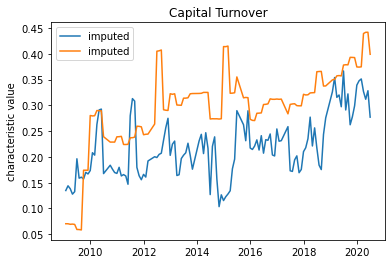

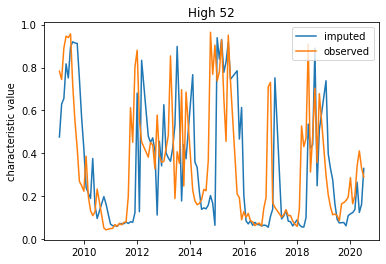

In [199]:
plt.plot(date_vals[ts_idxs.astype(int)], at_imputed, label="imputed")
plt.plot(date_vals[ts_idxs.astype(int)], percentile_rank_chars[ts_idxs.astype(int),290,26], label="imputed")
plt.ylabel("characteristic value")
plt.title("Capital Turnover")
plt.legend()
plt.show()
plt.plot(date_vals[ts_idxs.astype(int)], high_52_imputed, label="imputed")
plt.ylabel("characteristic value")
plt.plot(date_vals[ts_idxs.astype(int)], percentile_rank_chars[ts_idxs.astype(int),290,42], label="observed")
plt.title("High 52")
plt.legend()
plt.show()

In [168]:
chars

array(['ME', 'R2_1', 'D2P', 'SPREAD', 'RVAR', 'VAR', 'IdioVol', 'TURN',
       'SUV', 'R12_7', 'CF2P', 'E2P', 'R12_2', 'S2P', 'B2M', 'CF2B', 'AT',
       'A2ME', 'Q', 'PROF', 'PM', 'PCM', 'BETA_m', 'C2A', 'OL', 'ROE',
       'CTO', 'ATO', 'LEV', 'NOA', 'ROA', 'RNA', 'OP', 'NI', 'INV',
       'BETA_d', 'R36_13', 'D2A', 'FC2Y', 'SGA2S', 'OA', 'AC', 'HIGH52',
       'R60_13', 'DPI2A'], dtype='<U7')

(648, 22630, 45)